# NLIW depression supp materials plot

***Plot deets***
1. Full C
2. Full w'
3. Full w'c'
4. Filtered w'c'
5. Filtered w'c'_z with contours


In [1]:
import os
import glob
import numpy as np
import xarray as xr
import cmocean.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from d2spike.utils import nan_gauss_xr

import seaborn as sns
from wootils.plotnice import saveagu, vert_stack, plot_align, basic_ts, plot_axislabels

import sys
sys.path.insert(0, '../')
from cflux_fluxfuncs import get_nliw_times, calc_flux, get_nliw_fronts, reynolds_decomp
from cflux_basefuncs import load_c, load_ntu, rotate_data

sns.set()
sns.set_style("white")
sns.set_style("ticks")
# Set the tick length
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['ytick.minor.size'] = 0

# sudo mount -t drvfs '\\drive.irds.uwa.edu.au\OGS-ODFDA-001' /mnt/share

In [2]:
field_trip = 'RS2019'
wave_type = 'NLIW'
temp_file = 'RowleyShoals_Gridded_Mooring_T_SBE56.nc'
land_temp = 'RowleyShoals_L150_SBE56Data.nc'
moor = 'T150'

In [6]:
# Set key data directories and outputs
project_root = r'/mnt/c/Users/00099894/Large_Data/Experiments'
data_dir = r'/mnt/c/Users/00099894/Large_Data/Papers/cflux_nliw'
work_dir = r'/mnt/c/Users/00099894/OneDrive - The University of Western Australia/UWA/PhD'
load_dir = os.path.join(project_root, field_trip, wave_type)

fig_dir = f'{wave_type}_figures'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

## Load the data for event 5

In [10]:
# Load temp data
temp_nc = os.path.join(project_root, field_trip, temp_file)
ds_temp = xr.open_dataset(temp_nc, group=moor)
ds_temp.close()

# Load lander temp data
land_nc = os.path.join(project_root, field_trip, land_temp)
ds_land = xr.open_dataset(land_nc, group='L150_SBE56_T__881')
ds_land.close()

sig_file = 'SIG_meandataENU.nc'
sug_full = os.path.join(data_dir, 'dataset', sig_file)
ds_sig = xr.open_dataset(sug_full)
# echo_dp = xr.DataArray(data=ds_sig['echo'].values[:,np.newaxis], dims=['time', 'height'],\
#                        coords={'time': ds_sig['echo'].time, 'height': [5.0]})
# sig_mean_ssc = load_c(echo_dp, ds_temp, os.path.join(work_dir, 'pl'), field_trip)

ds_l_ntu = load_ntu(work_dir, '0360_burstmedian', mooring='L150')
ds_l_ntu = ds_l_ntu.rename({'Datenum':'time'})
ssc_good = (ds_l_ntu*2.62 - 4.38)/2.33

ds_h_ntu = load_ntu(work_dir, '0359_burstmedian', mooring='L150')
ssc_uppp = (ds_h_ntu*2.52 - 3.95)/2.33

In [11]:
wav_tx = get_nliw_times()
wav_fronts = get_nliw_fronts()

# c_wave = 0.6
cb_labels = ['$\\overline{C_t}$', '$-\overline{W}\overline{C}_z$', '$-\overline{w\'c\'}_z$',\
                '$-\overline{U}\overline{C}_x$']

ylim = (2.4,7.42)
flx_bar = 0.149
gf_h, gf_t = 4, 300
thin_v, thin_t = 1, 1
sett = 0.000

In [12]:
# Load wave data
for ii, (wt, wf) in enumerate(zip(wav_tx, wav_fronts)):
    if (ii == 1):
    
        # Load fluxes
        sig_fil = f'{wave_type}_E{int(ii+1)}_fluxattrs.nc'
        vel_file = os.path.join(load_dir, sig_fil)
        ds = xr.open_dataset(vel_file)
        xr.Dataset.close(ds)
        print(f'Loaded {sig_fil}')


        sig_fil = f'{wave_type}_{int(ii+1)}_ENU.nc'
        vel_file = os.path.join(load_dir, sig_fil)
        ds_turb = xr.open_dataset(vel_file)
        xr.Dataset.close(ds_turb)

        sig_fil = f'{wave_type}_{int(ii+1)}_echo.nc'
        vel_file = os.path.join(load_dir, sig_fil)
        ds_echo = xr.open_dataset(vel_file)
        xr.Dataset.close(ds_echo)        

        start = np.timedelta64(5, 'm')
        end = (1*(ds.time.values[-1] - ds.time.values[0])/4).astype('timedelta64[ns]')

        # tx_sig = (ds.time.values >= ds.time.values[0] + start) &\
        #             (ds.time.values <= ds.time.values[0] + end)
        tx_turb = (ds_turb.time.values >= ds.time.values[0] + start) &\
                    (ds_turb.time.values <= ds.time.values[0] + end)
        tx_echo = (ds_echo.time.values >= ds.time.values[0] + start) &\
                    (ds_echo.time.values <= ds.time.values[0] + end)
                
        # temp_ix = (ds_temp['time'].values >= ds.time.values[0] + start) &\
        #             (ds_temp['time'].values <= ds.time.values[0] + end)
        # land_ix = (ds_land['time'].values >= ds.time.values[0] + start) &\
        #             (ds_land['time'].values <= ds.time.values[0] + end)
        
        # (u_r, v_r), theta_sig = rotate_data(ds_turb.isel(time=tx_turb))                        
        # u_r_mean = ds['u_mean'].sel(height=5.02).isel(time=tx_sig)

        c_turb, beam_cor = load_c(ds_echo['__xarray_dataarray_variable__'].isel(time=tx_echo),\
                            ds_temp, os.path.join(work_dir, 'pl'), field_trip, bs_cutoff=80,\
                            bs_corrected=True)
        
        _, w_turb = reynolds_decomp(ds_turb['enu'].sel(cartesian_axes=3).isel(time=tx_turb).interpolate_na(dim='time'), [gf_h,gf_t])
        # new_w = np.full_like(ds['w_mean'].values, np.nan)
        # for ii, hh in enumerate(ds.height):
        #     new_w[ii,:] = ds['w_mean'].sel(height=hh).values - ds['w_mean'].sel(height=hh).mean().values - sett
        # ds['w_mean'] = xr.DataArray(new_w, dims=['height', 'time'], coords={'height': ds.height, 'time': ds.time})
        
        c_turb = c_turb.sel(height=slice(0.5, None)).T
        # xl = np.arange(8065, 8081)
        # c_turb.data[:, xl] = np.nan
        # sig_mean_ssc = nan_gauss_xr(c_turb.sel(height=3.0, method='nearest'), 75*4)[::30]
        
        break

Loaded NLIW_E2_fluxattrs.nc
Nearfield correction applied to cells within 0.63 m


In [13]:
c_mean, c_turb_turb = reynolds_decomp(c_turb.interpolate_na(dim='time'), [gf_h,gf_t])

In [14]:
w_turb_mean = nan_gauss_xr(w_turb, [gf_h,gf_t])

In [15]:
wc_mean = nan_gauss_xr((c_turb_turb * w_turb), [gf_h,gf_t])


In [16]:
wc_z_turb = nan_gauss_xr(-1*(c_turb_turb * w_turb).differentiate('height'),\
                                [gf_h, gf_t], axis=[0,1])

In [17]:
p_start = ds.time.values[0] + np.timedelta64(32, 'm')
p_end = ds.time.values[0] + (1*(ds.time.values[-1] - ds.time.values[0])/4).astype('timedelta64[ns]')

p_turb = (c_turb.time.values >= p_start) &\
            (c_turb.time.values <= p_end)

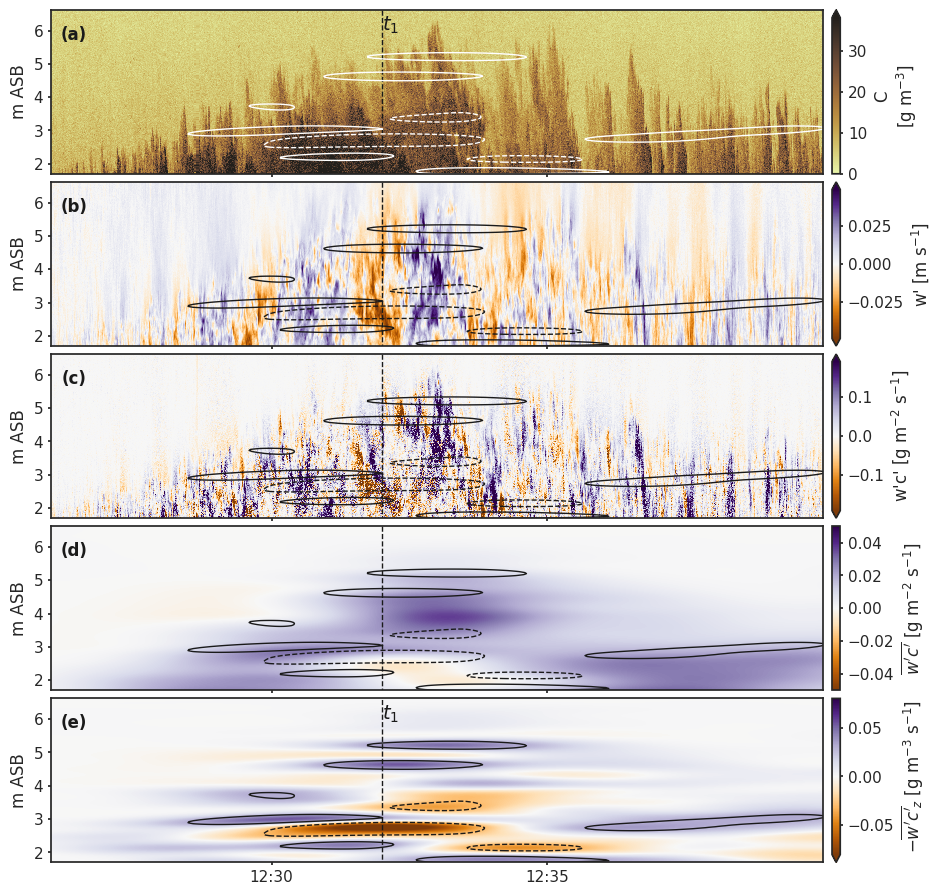

In [18]:
fig, ax = vert_stack(5, hsize=16.6/1.4, vsize=3.1/1.4, hspace=0.05)

# ax[0].fill_between(c_turb.time, 0.5, 1.5, color='grey', alpha=1)
xp = np.arange(1585, 1602)
c_turb.isel(time=p_turb).drop_isel(time=xp).plot(ax=ax[0], cmap=cm.turbid, vmin=0, vmax=38,\
            cbar_kwargs={'pad': 0.01, 'label': 'C\n[g m$^{-3}$]'})
# ax[0].fill_between(c_turb.time, 0.5, 0.9, color='grey', alpha=1)

w_turb.isel(time=p_turb).plot(ax=ax[1], cmap='PuOr', vmin=-0.049, vmax=0.049,\
            cbar_kwargs={'pad': 0.01, 'label': 'w\' [m s$^{-1}$]'})

(c_turb_turb * w_turb).isel(time=p_turb).plot(ax=ax[2], cmap='PuOr', vmin=-0.19, vmax=0.19,\
            cbar_kwargs={'pad': 0.01, 'label': 'w\'c\' [g m$^{-2}$ s$^{-1}$]'})

wc_mean.isel(time=p_turb).plot(ax=ax[3], cmap='PuOr', vmin=-0.05, vmax=0.05,\
            cbar_kwargs={'pad': 0.01, 'label': '$\overline{w\'c\'}$ [g m$^{-2}$ s$^{-1}$]'})

wc_z_turb.isel(time=p_turb).plot(ax=ax[4], cmap='PuOr', vmin=-0.08, vmax=0.08,\
            cbar_kwargs={'pad': 0.01, 'label': '$-\overline{w\'c\'}_z$ [g m$^{-3}$ s$^{-1}$]'},
            center=0)

myFmt = mdates.DateFormatter('%H:%M')
ax[-1].xaxis.set_major_formatter(myFmt)

for xiax, x in enumerate(ax):
    ccc = 'k'
    x.vlines(wav_fronts[1], ymin=0.5, ymax=c_turb.height.values[-1], color=ccc, ls='--', lw=1)
for wf, wl in zip(wav_fronts[1], ['$t_0$', '$t_1$', '$t_2$']):
    if wl == '$t_1$':
        ax[0].text(wf, 6., wl, color='k', fontsize=14, ha='left', zorder=10, weight='bold')
        ax[-1].text(wf, 6., wl, color='k', fontsize=14, ha='left', zorder=10, weight='bold')

for i, x in enumerate(ax):
    if i == 0:
        ccc = 'w'
    else:
        ccc = 'k'
    wc_z_turb.plot.contour(ax=x, colors=ccc, linewidths=1,\
                        levels=[-0.03, 0.03], add_colorbar=False)
    # if i < 2:
    #     x.set_ylim(1.01, 7.42)
    # else:
    x.set_ylim(1.7, 6.62)
    x.set_ylabel('m ASB')
    x.set_title('')
    x.set_xlim(p_start + np.timedelta64(4,'m'), p_end - np.timedelta64(150,'s'))
    if i != 4:
        x.set_xticklabels([])
    x.set_xlabel('')
    
plot_axislabels(ax, pos='topleft')

for label in ax[-1].get_xticklabels():
    label.set_rotation(0)        # Unrotate (set to 0 degrees)
    label.set_ha('center')    

In [19]:
# saveagu(os.path.join(fig_dir, f'{wave_type}_E{int(ii+1)}_supp_s1v2'), fig)